In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tldextract
import nltk
import plotly.express as px
import plotly.graph_objects as go
import string

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from plotly.subplots import make_subplots

from datetime import datetime
from collections import OrderedDict

# gensim
from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
#read files from source and put into dataframe
df_train = pd.read_csv("data/fake news detection (FakeNewsNet)/fnn_train.csv", parse_dates = ['date'])

In [3]:
df_train.head(5)

id                       date               speaker  \
0  3106  2011-01-25 06:00:00-05:00         Joe Wilkinson   
1  5655  2012-04-02 11:42:20-04:00            Rick Scott   
2  3506  2011-04-01 09:49:05-04:00        J.D. Alexander   
3  3450  2011-03-21 12:20:02-04:00             Paul Ryan   
4  4776  2011-11-13 07:30:00-05:00  Rodney Frelinghuysen   

                                           statement  \
0  A national organization says Georgia has one o...   
1  Says Barack Obama's health care law "will be t...   
2  Says the Southwest Florida Water Management Di...   
3  "The Congressional Budget Office has this econ...   
4  Says the Treasury Department "says 41 percent ...   

                                             sources  \
0  ['http://www.ajc.com/news/georgia-politics-ele...   
1  ['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...   
2  ['http://www.tampabay.com/news/politics/gubern...   
3  ['http://www.cnn.com/2011/POLITICS/03/17/gop.b...   
4  ['http://frelinghuysen.house.gov/index.cfm?sec...   

                             paragraph_based_content  \
0  ['A coalition of government watchdog groups la...   
1  ['As Supreme Court justices embarked on three ...   
2  ["Here's a new one: The Senate budget committe...   
3  ['Recently, House Budget chairman Paul Ryan, R...   
4  ['The millionaires’ tax proposal made its late...   

                              fullText_based_content label_fnn  
0  A coalition of government watchdog groups last...      fake  
1  As Supreme Court justices embarked on three da...      fake  
2  Here's a new one: The Senate budget committee ...      fake  
3  Recently, House Budget chairman Paul Ryan, R-W...      real  
4  The millionaires’ tax proposal made its latest...      fake

In [4]:
df_train.isna().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

In [6]:
#read files from source and put into dataframe
df_test = pd.read_csv("data/fake news detection (FakeNewsNet)/fnn_test.csv", parse_dates = ['date'])

In [7]:
df_test.head(5)

id                       date                           speaker  \
0  1678  2010-04-11 16:37:40-04:00                           Jon Kyl   
1  1820  2010-05-23 18:11:09-04:00                    Michael Steele   
2  1624  2010-03-26 10:24:21-04:00                      John Boehner   
3  1576  2010-03-12 11:45:14-05:00  America's Health Insurance Plans   
4  1770  2010-05-07 11:54:44-04:00                 Michael Bloomberg   

                                           statement  \
0  "President Obama himself attempted to filibust...   
1  In Hawaii, "they don't have a history of throw...   
2  "Our national debt ... is on track to exceed t...   
3  "Health insurance companies' costs are only 4 ...   
4  "We can prevent terror suspects from boarding ...   

                                             sources  \
0  ['http://abcnews.go.com/ThisWeek/video/supreme...   
1  ['http://www.starbulletin.com/news/bulletin/94...   
2  ['http://www.desmoinesregister.com/article/201...   
3  ['http://www.youtube.com/watch?v=4O8CxZ1OD58',...   
4  ['http://www.huffingtonpost.com/michael-bloomb...   

                             paragraph_based_content  \
0  ['U.S. Supreme Court Justice John Paul Stevens...   
1  ["On ABC's This Week, the chairmen of the Repu...   
2  ['Ever since Barack Obama became president and...   
3  ["As the battle over health care reform approa...   
4  ['In the wake of a foiled car bomb attempt in ...   

                              fullText_based_content label_fnn  
0  U.S. Supreme Court Justice John Paul Stevens a...      real  
1  On ABC's This Week, the chairmen of the Republ...      real  
2  Ever since Barack Obama became president and b...      real  
3  As the battle over health care reform approach...      real  
4  In the wake of a foiled car bomb attempt in Ti...      real

In [8]:
df_test.isna().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

In [9]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [10]:
df.head(5)

id                       date               speaker  \
0  3106  2011-01-25 06:00:00-05:00         Joe Wilkinson   
1  5655  2012-04-02 11:42:20-04:00            Rick Scott   
2  3506  2011-04-01 09:49:05-04:00        J.D. Alexander   
3  3450  2011-03-21 12:20:02-04:00             Paul Ryan   
4  4776  2011-11-13 07:30:00-05:00  Rodney Frelinghuysen   

                                           statement  \
0  A national organization says Georgia has one o...   
1  Says Barack Obama's health care law "will be t...   
2  Says the Southwest Florida Water Management Di...   
3  "The Congressional Budget Office has this econ...   
4  Says the Treasury Department "says 41 percent ...   

                                             sources  \
0  ['http://www.ajc.com/news/georgia-politics-ele...   
1  ['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...   
2  ['http://www.tampabay.com/news/politics/gubern...   
3  ['http://www.cnn.com/2011/POLITICS/03/17/gop.b...   
4  ['http://frelinghuysen.house.gov/index.cfm?sec...   

                             paragraph_based_content  \
0  ['A coalition of government watchdog groups la...   
1  ['As Supreme Court justices embarked on three ...   
2  ["Here's a new one: The Senate budget committe...   
3  ['Recently, House Budget chairman Paul Ryan, R...   
4  ['The millionaires’ tax proposal made its late...   

                              fullText_based_content label_fnn  
0  A coalition of government watchdog groups last...      fake  
1  As Supreme Court justices embarked on three da...      fake  
2  Here's a new one: The Senate budget committee ...      fake  
3  Recently, House Budget chairman Paul Ryan, R-W...      real  
4  The millionaires’ tax proposal made its latest...      fake

In [11]:
df.columns

Index(['id', 'date', 'speaker', 'statement', 'sources',
       'paragraph_based_content', 'fullText_based_content', 'label_fnn'],
      dtype='object')

In [12]:
df.rename(columns={"fullText_based_content": "Content", "label_fnn": "Label"}, inplace = True)
df['statement']= df['statement'].astype('string')
df['Content']= df['Content'].astype('string')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16266 entries, 0 to 16265
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       16266 non-null  int64 
 1   date                     16266 non-null  object
 2   speaker                  16266 non-null  object
 3   statement                16266 non-null  string
 4   sources                  16266 non-null  object
 5   paragraph_based_content  16266 non-null  object
 6   Content                  16266 non-null  string
 7   Label                    16266 non-null  object
dtypes: int64(1), object(5), string(2)
memory usage: 1016.8+ KB


In [14]:
realnews = (df['Label'] == 'real').sum()
fakenews = (df['Label'] == 'fake').sum()

print(f'Fake News: {fakenews}')
print(f'Real News: {realnews}')

print(f'Percentage of Fake News: {round(fakenews / (df.Label.count()), 3)*100}%')
print(f'Percentage of Real News: {round(realnews / (df.Label.count()), 3)*100}%')

Fake News: 8039
Real News: 8227
Percentage of Fake News: 49.4%
Percentage of Real News: 50.6%


In [15]:
df['sources'] = df['sources'].str.replace("\[|]", "")

In [16]:
new = df["sources"].str.split(",", n = 5, expand = True)

In [17]:
#We gonna keep one source only and drop the rest, since the database uses multiple sources to check
#on the same statement and text.
df["Source1"]= new[0]
df['Source1'] = df['Source1'].str.replace("\'", "")
m = df['Source1'].str.extract('(?<=http://)(.*?)(?=/)|(?<=https://)(.*?)(?=/)')
m = m[0].fillna(m[1]).fillna(df['Source1'])
df['Domain'] = m

In [18]:
df = df[~df.Domain.str.contains("a0https:")]
df = df[~df.Domain.str.contains("xn--http-996a")]

In [19]:
#df['SourceDomain'] = df['Domain'].apply(lambda url: tldextract.extract(url).domain)

In [20]:
df.head(5)

id                       date               speaker  \
0  3106  2011-01-25 06:00:00-05:00         Joe Wilkinson   
1  5655  2012-04-02 11:42:20-04:00            Rick Scott   
2  3506  2011-04-01 09:49:05-04:00        J.D. Alexander   
3  3450  2011-03-21 12:20:02-04:00             Paul Ryan   
4  4776  2011-11-13 07:30:00-05:00  Rodney Frelinghuysen   

                                           statement  \
0  A national organization says Georgia has one o...   
1  Says Barack Obama's health care law "will be t...   
2  Says the Southwest Florida Water Management Di...   
3  "The Congressional Budget Office has this econ...   
4  Says the Treasury Department "says 41 percent ...   

                                             sources  \
0  'http://www.ajc.com/news/georgia-politics-elec...   
1  'http://www.youtube.com/watch?v=TaC0mKApf9Q&fe...   
2  'http://www.tampabay.com/news/politics/guberna...   
3  'http://www.cnn.com/2011/POLITICS/03/17/gop.bu...   
4  'http://frelinghuysen.house.gov/index.cfm?sect...   

                             paragraph_based_content  \
0  ['A coalition of government watchdog groups la...   
1  ['As Supreme Court justices embarked on three ...   
2  ["Here's a new one: The Senate budget committe...   
3  ['Recently, House Budget chairman Paul Ryan, R...   
4  ['The millionaires’ tax proposal made its late...   

                                             Content Label  \
0  A coalition of government watchdog groups last...  fake   
1  As Supreme Court justices embarked on three da...  fake   
2  Here's a new one: The Senate budget committee ...  fake   
3  Recently, House Budget chairman Paul Ryan, R-W...  real   
4  The millionaires’ tax proposal made its latest...  fake   

                                             Source1                   Domain  
0  http://www.ajc.com/news/georgia-politics-elect...              www.ajc.com  
1  http://www.youtube.com/watch?v=TaC0mKApf9Q&fea...          www.youtube.com  
2  http://www.tampabay.com/news/politics/gubernat...         www.tampabay.com  
3  http://www.cnn.com/2011/POLITICS/03/17/gop.bud...              www.cnn.com  
4  http://frelinghuysen.house.gov/index.cfm?secti...  frelinghuysen.house.gov

In [21]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# Data cleaning
def remove_tag(string):
    text=re.sub('<.*?>','',string)
    return text
def remove_mention(text):
    line=re.sub(r'@\w+','',text)
    return line
def remove_hash(text):
    line=re.sub(r'#\w+','',text)
    return line
def remove_newline(string):
    text=re.sub('\n','',string)
    return text
def remove_url(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text
def remove_number(text):
    line=re.sub(r'[0-9]+','',text)
    return line
def remove_punct(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)
    #string="".join(line)
    return line
def text_strip(string):
    line=re.sub('\s{2,}', ' ', string.strip())
    return line
def remove_punctuation(text):
    line = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    return line

In [22]:
df['refine_statement']=df['statement'].str.lower()
df['refine_statement']=df['refine_statement'].apply(lambda x:remove_tag(str(x)))
df['refine_statement']=df['refine_statement'].apply(lambda x:remove_mention(str(x)))
df['refine_statement']=df['refine_statement'].apply(lambda x:remove_hash(str(x)))
df['refine_statement']=df['refine_statement'].apply(lambda x:remove_newline(x))
df['refine_statement']=df['refine_statement'].apply(lambda x:remove_url(x))
df['refine_statement']=df['refine_statement'].apply(lambda x:remove_number(x))
df['refine_statement']=df['refine_statement'].apply(lambda x:remove_punct(x))
df['refine_statement']=df['refine_statement'].apply(lambda x:text_strip(x))
df['refine_statement']=df['refine_statement'].apply(lambda x:remove_punctuation(x))
df['statement_length']=df['refine_statement'].str.split().map(lambda x: len(x))

df['refine_Content']=df['Content'].str.lower()
df['refine_Content']=df['refine_Content'].apply(lambda x:remove_tag(str(x)))
df['refine_Content']=df['refine_Content'].apply(lambda x:remove_mention(str(x)))
df['refine_Content']=df['refine_Content'].apply(lambda x:remove_hash(str(x)))
df['refine_Content']=df['refine_Content'].apply(lambda x:remove_newline(x))
df['refine_Content']=df['refine_Content'].apply(lambda x:remove_url(x))
df['refine_Content']=df['refine_Content'].apply(lambda x:remove_number(x))
df['refine_Content']=df['refine_Content'].apply(lambda x:remove_punct(x))
df['refine_Content']=df['refine_Content'].apply(lambda x:text_strip(x))
df['refine_Content']=df['refine_Content'].apply(lambda x:remove_punctuation(x))
df['Content_length']=df['refine_Content'].str.split().map(lambda x: len(x))


In [23]:
df = df.drop('paragraph_based_content'and'sources' and 'statement' and 'Content',axis=1)
columnsTitles = ['id', 'date', 'speaker', 'Source1', 'Domain', 'refine_statement', 'statement_length', 'refine_Content', 'Content_length', 'Label']
df = df.reindex(columns=columnsTitles)

In [24]:
df.head(5)

id                       date               speaker  \
0  3106  2011-01-25 06:00:00-05:00         Joe Wilkinson   
1  5655  2012-04-02 11:42:20-04:00            Rick Scott   
2  3506  2011-04-01 09:49:05-04:00        J.D. Alexander   
3  3450  2011-03-21 12:20:02-04:00             Paul Ryan   
4  4776  2011-11-13 07:30:00-05:00  Rodney Frelinghuysen   

                                             Source1                   Domain  \
0  http://www.ajc.com/news/georgia-politics-elect...              www.ajc.com   
1  http://www.youtube.com/watch?v=TaC0mKApf9Q&fea...          www.youtube.com   
2  http://www.tampabay.com/news/politics/gubernat...         www.tampabay.com   
3  http://www.cnn.com/2011/POLITICS/03/17/gop.bud...              www.cnn.com   
4  http://frelinghuysen.house.gov/index.cfm?secti...  frelinghuysen.house.gov   

                                    refine_statement  statement_length  \
0  a national organization says georgia has one o...                12   
1  says barack obamas health care law will be the...                12   
2  says the southwest florida water management di...                25   
3  the congressional budget office has this econo...                45   
4  says the treasury department says percent of a...                39   

                                      refine_Content  Content_length Label  
0  a coalition of government watchdog groups last...             652  fake  
1  as supreme court justices embarked on three da...             950  fake  
2  heres a new one the senate budget committee ch...             692  fake  
3  recently house budget chairman paul ryan rwis ...            1138  real  
4  the millionaires’ tax proposal made its latest...             561  fake

In [25]:
df_realnews = df[df['Label'] == 'real']
df_fakenews = df[df['Label'] == 'fake']

In [26]:
df_realnews.head(5)

id                       date          speaker  \
3    3450  2011-03-21 12:20:02-04:00        Paul Ryan   
5    8934  2014-02-17 00:00:00-05:00  Terry McAuliffe   
8    5716  2012-04-11 07:30:00-04:00  Robert Menendez   
9   13207  2016-10-07 10:00:24-04:00      Josh Hawley   
10   8296  2013-09-23 10:27:49-04:00       Rick Scott   

                                              Source1                 Domain  \
3   http://www.cnn.com/2011/POLITICS/03/17/gop.bud...            www.cnn.com   
5   https://governor.virginia.gov/policy/executive...  governor.virginia.gov   
8          http://www.youtube.com/watch?v=Cvo_fSKHkLY        www.youtube.com   
9   https://www.youtube.com/watch?v=D_zzqEA9N2A&fe...        www.youtube.com   
10  http://www.myfwc.com/license/recreational/salt...          www.myfwc.com   

                                     refine_statement  statement_length  \
3   the congressional budget office has this econo...                45   
5   seventy percent of all uninsured live in house...                16   
8   says the united states actually exports more g...                23   
9   says he fought obama at the supreme court — an...                11   
10   you have to get a license to fish on our beaches                11   

                                       refine_Content  Content_length Label  
3   recently house budget chairman paul ryan rwis ...            1138  real  
5   gov terry mcauliffe is urging the general asse...             227  real  
8   drill it in the united states keep it in the u...             464  real  
9   throughout the primary and general election ca...             929  real  
10  indulge us this fantasy beckoned by summer’s e...             475  real

In [27]:
df_fakenews.head(5)

id                       date               speaker  \
0  3106  2011-01-25 06:00:00-05:00         Joe Wilkinson   
1  5655  2012-04-02 11:42:20-04:00            Rick Scott   
2  3506  2011-04-01 09:49:05-04:00        J.D. Alexander   
4  4776  2011-11-13 07:30:00-05:00  Rodney Frelinghuysen   
6  1415  2010-01-21 17:37:57-05:00           Chain email   

                                             Source1  \
0  http://www.ajc.com/news/georgia-politics-elect...   
1  http://www.youtube.com/watch?v=TaC0mKApf9Q&fea...   
2  http://www.tampabay.com/news/politics/gubernat...   
4  http://frelinghuysen.house.gov/index.cfm?secti...   
6  http://michaelconnelly.viviti.com/entries/gene...   

                       Domain  \
0                 www.ajc.com   
1             www.youtube.com   
2            www.tampabay.com   
4     frelinghuysen.house.gov   
6  michaelconnelly.viviti.com   

                                    refine_statement  statement_length  \
0  a national organization says georgia has one o...                12   
1  says barack obamas health care law will be the...                12   
2  says the southwest florida water management di...                25   
4  says the treasury department says percent of a...                39   
6  the house health care bill provides for free a...                22   

                                      refine_Content  Content_length Label  
0  a coalition of government watchdog groups last...             652  fake  
1  as supreme court justices embarked on three da...             950  fake  
2  heres a new one the senate budget committee ch...             692  fake  
4  the millionaires’ tax proposal made its latest...             561  fake  
6  a chain email written by former attorney micha...             653  fake

In [28]:
print(df_realnews.groupby('Label')['speaker'].value_counts().head(5),'\n')
print(df_fakenews.groupby('Label')['speaker'].value_counts().head(5),'\n')
print(df_realnews.groupby('Label')['Domain'].value_counts().head(5),'\n')
print(df_fakenews.groupby('Label')['Domain'].value_counts().head(5),'\n')

Label  speaker        
real   Barack Obama       436
       Donald Trump       212
       Hillary Clinton    200
       Bernie Sanders     118
       Mitt Romney        112
Name: speaker, dtype: int64 

Label  speaker       
fake   Donald Trump      520
       Bloggers          487
       Facebook posts    450
       Viral image       314
       Chain email       154
Name: speaker, dtype: int64 

Label  Domain            
real   www.youtube.com       845
       twitter.com           351
       www.politifact.com    295
       www.whitehouse.gov    191
       www.facebook.com      168
Name: Domain, dtype: int64 

Label  Domain            
fake   www.facebook.com      768
       www.youtube.com       738
       twitter.com           379
       www.politifact.com    293
       docs.google.com       122
Name: Domain, dtype: int64 



Text(0.5, 1.0, 'Fake News - Most Used Words in Statement')

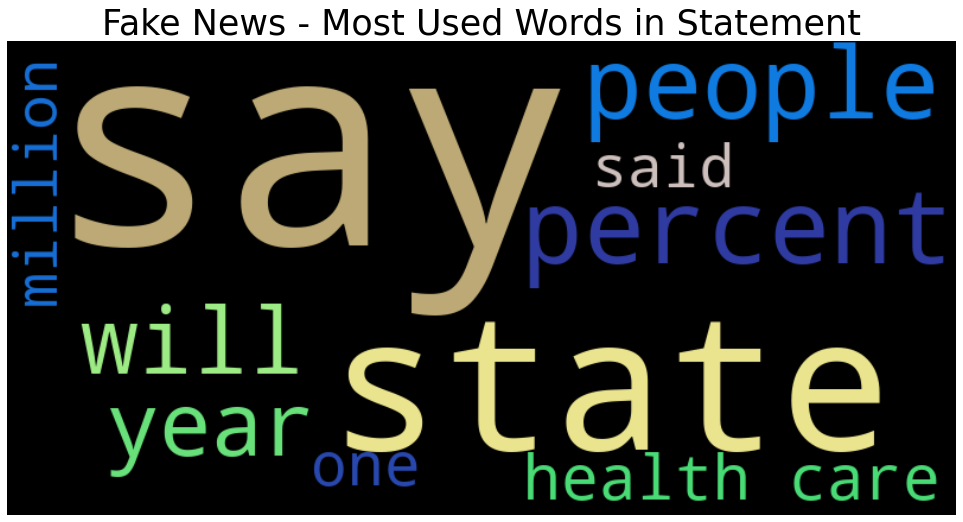

In [29]:
fig, (ax2) = plt.subplots(1,1,figsize=[17, 10])
wordcloud2 = WordCloud(background_color='black',colormap="terrain_r",width=800,height=400, max_words= 10).generate(" ".join(df_fakenews['refine_statement']))

ax2.imshow(wordcloud2,interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Fake News - Most Used Words in Statement',fontsize=35)

Text(0.5, 1.0, 'Real News - Most Used Words in Statement')

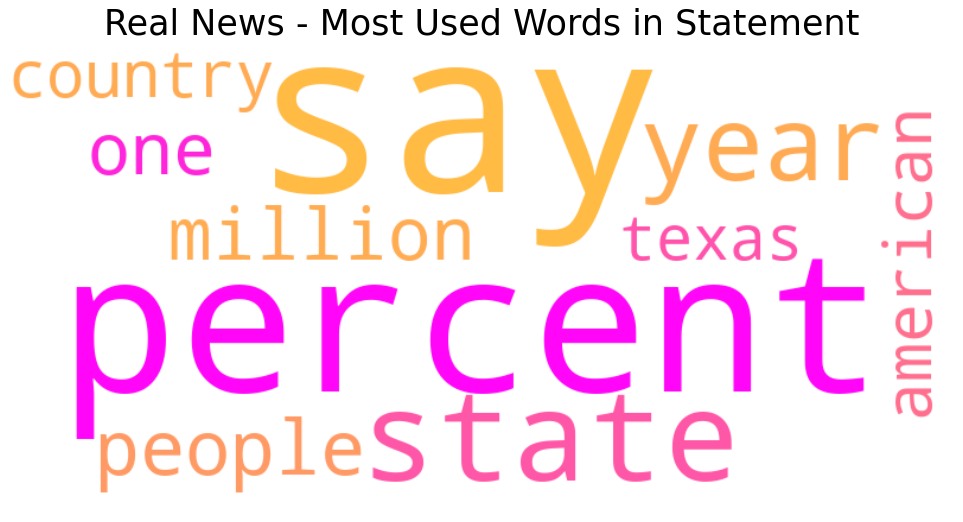

In [30]:
fig, (ax2) = plt.subplots(1,1,figsize=[17, 10])
wordcloud2 = WordCloud(background_color='white',colormap="spring",width=800,height=400, max_words=10).generate(" ".join(df_realnews['refine_statement']))

ax2.imshow(wordcloud2,interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Real News - Most Used Words in Statement',fontsize=35)

Text(0.5, 1.0, 'Fake News - Most Used Words in Content')

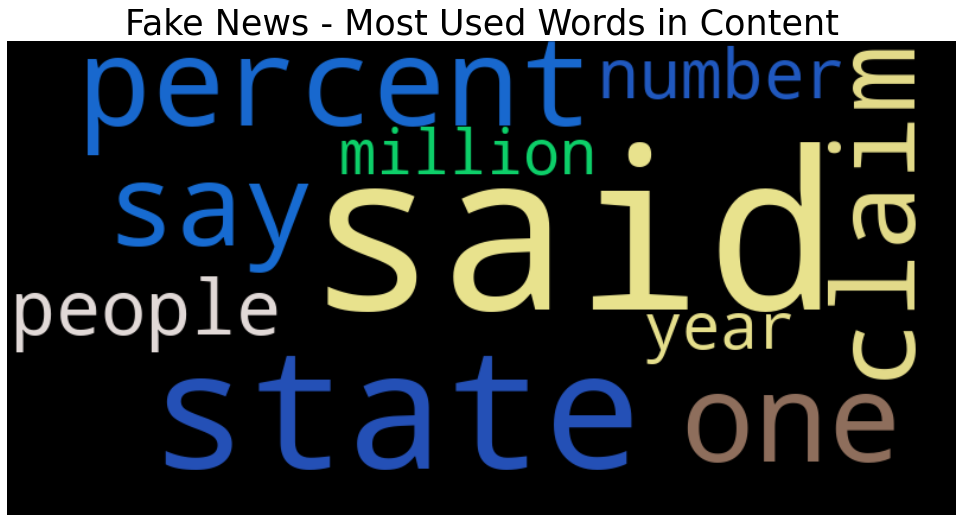

In [31]:
fig, (ax2) = plt.subplots(1,1,figsize=[17, 10])
wordcloud2 = WordCloud(background_color='black',colormap="terrain_r",width=800,height=400, max_words=10).generate(" ".join(df_fakenews['refine_Content']))

ax2.imshow(wordcloud2,interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Fake News - Most Used Words in Content',fontsize=35)

Text(0.5, 1.0, 'Real News - Most Used Words in Content')

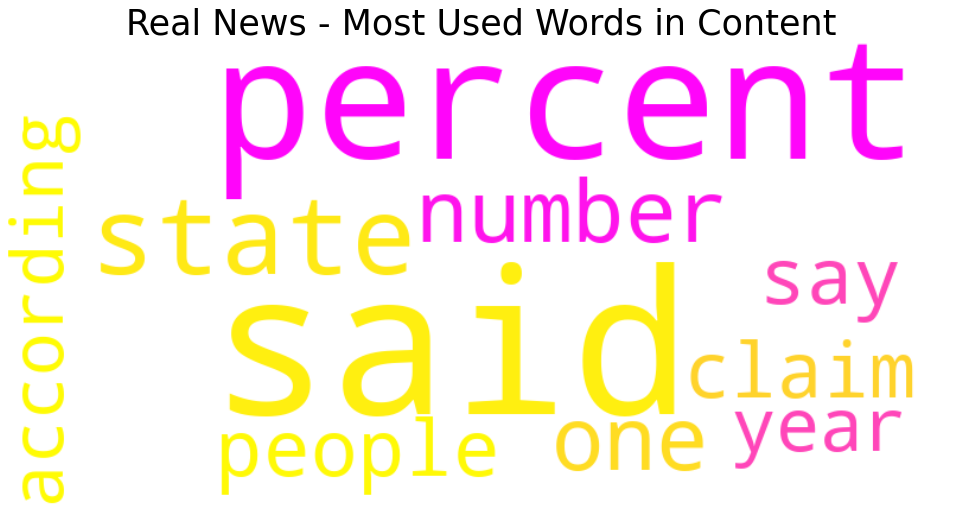

In [32]:
fig, (ax2) = plt.subplots(1,1,figsize=[17, 10])
wordcloud2 = WordCloud(background_color='white',colormap="spring",width=800,height=400,max_words=10).generate(" ".join(df_realnews['refine_Content']))

ax2.imshow(wordcloud2,interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Real News - Most Used Words in Content',fontsize=35)

In [33]:
fig = go.Figure()

fig.add_trace(go.Violin(y=df_realnews['statement_length'], box_visible=False, line_color='black', meanline_visible=True, fillcolor='magenta', opacity=0.6,name="True", x0='True News'))
fig.add_trace(go.Violin(y=df_fakenews['statement_length'], box_visible=False, line_color='black', meanline_visible=True, fillcolor='skyblue', opacity=0.6,name="Fake", x0='Fake News') )

fig.update_traces(box_visible=False, meanline_visible=True)
fig.update_layout(title_text="Violin - News Statement Length",title_x=0.5)
fig.show()

In [34]:
fig = go.Figure()

fig.add_trace(go.Violin(y=df_realnews['Content_length'], box_visible=False, line_color='black', meanline_visible=True, fillcolor='green', opacity=0.6,name="True", x0='True News'))
fig.add_trace(go.Violin(y=df_fakenews['Content_length'], box_visible=False, line_color='black', meanline_visible=True, fillcolor='red', opacity=0.6,name="Fake", x0='Fake News') )

fig.update_traces(box_visible=True, meanline_visible=True)
fig.update_layout(title_text="Violin - Content Length",title_x=0.5)
fig.show()

In [35]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english', ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english', ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english', ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [36]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [37]:
common_words = get_top_n_trigram(df_realnews['refine_statement'], 20)
df4 = pd.DataFrame(common_words,columns=['word','count'])
df4.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams used in Real News Title',color='blue')

In [38]:
common_words = get_top_n_trigram(df_fakenews['refine_statement'], 20)
df4 = pd.DataFrame(common_words,columns=['word','count'])
df4.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams used in Fake News Title',color='red')

In [39]:
common_words = get_top_n_trigram(df_realnews['refine_Content'], 20)
df4 = pd.DataFrame(common_words,columns=['word','count'])
df4.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams used in Real News Content',color='blue')

In [40]:
common_words = get_top_n_trigram(df_fakenews['refine_Content'], 20)
df4 = pd.DataFrame(common_words,columns=['word','count'])
df4.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams used in Fake News Content',color='red')

## Prepare data for classification modelling

In [41]:
#Replace real and fake into numeric

df.Label.replace('real', 0, inplace = True)
df.Label.replace('fake', 1, inplace = True)

In [42]:
# Split the data into X and y data sets
X = df.refine_Content
y = df.Label


In [43]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
X_train.head(5)

12332    the super pac ending spending fund is broadcas...
10979    a widespread internet post claims democratic p...
13671    cnn host piers morgan has joined the chorus of...
11374    on sept the national taxpayers union a conserv...
13635    del ken plum dfairfax recently renewed his cal...
Name: refine_Content, dtype: object

In [45]:
y.head(5)

0    1
1    1
2    1
3    0
4    1
Name: Label, dtype: int64

In [46]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,3), binary=True, stop_words='english', min_df = 0.1)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)



In [47]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,3), binary=True, stop_words='english', min_df = 0.1)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

## GRIDSEARCH TIME!

In [48]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve,f1_score, fbeta_score, make_scorer

def CVModeling (estimator, parameters, features, target):
    scoring = {'AUC': make_scorer (roc_auc_score), 'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score), 'F1': make_scorer(f1_score)}

    grid_search = GridSearchCV(estimator, parameters, cv= 5, scoring=scoring, refit='precision' , n_jobs=4, return_train_score=True)
    grid_search.fit(features, target)

    print ('Best parameters: {}'.format(grid_search.best_params_))
    print (f'Best score: {grid_search.best_score_:.3f}')
    
    
    AUC_test = np.round(np.mean(grid_search.cv_results_['mean_test_AUC']),3)
    AUC_test_std = np.mean(grid_search.cv_results_['std_test_AUC'])
    
    precision_test = np.round(np.mean(grid_search.cv_results_['mean_test_precision']),3)
    precision_test_std = np.mean(grid_search.cv_results_['std_test_precision'])
    
    recall_test = np.round(np.mean(grid_search.cv_results_['mean_test_recall']),3)
    recall_test_std = np.mean(grid_search.cv_results_['std_test_recall'])
    
    F1_test = np.round(np.mean(grid_search.cv_results_['mean_test_F1']),3)
    F1_test_std = np.mean(grid_search.cv_results_['std_test_F1'])
    
        
    print(f'Mean AUC test score: {AUC_test:.3f} +- {AUC_test_std:.3f}')
    print(f'Mean precision test score: {precision_test:.3f} +- {precision_test_std:.3f}')
    print(f'Mean recall test score: {recall_test:.3f} +- {recall_test_std:.3f}')
    print(f'Mean F1 test score: {F1_test:.3f} +- {F1_test_std:.3f}')
    print('\n')

    CVModeling_results = [AUC_test, precision_test, recall_test, F1_test]
    return CVModeling_results

# Try With Logistic Regression

In [49]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)

In [50]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [51]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [52]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=10000)
parameters ={'C' : [100, 200, 300, 400, 500]}
CVM1 = CVModeling(logit, parameters, X_train_cv1, y_train)
CVM2 = CVModeling(logit, parameters, X_train_cv2, y_train)

Best parameters: {'C': 400}
Best score: 0.676
Mean AUC test score: 0.678 +- 0.007
Mean precision test score: 0.676 +- 0.009
Mean recall test score: 0.659 +- 0.010
Mean F1 test score: 0.667 +- 0.006


Best parameters: {'C': 100}
Best score: 0.698
Mean AUC test score: 0.689 +- 0.011
Mean precision test score: 0.698 +- 0.011
Mean recall test score: 0.643 +- 0.014
Mean F1 test score: 0.669 +- 0.012




In [53]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

mnb = MultinomialNB()
parameters = {'alpha' : [0.2, 0.4, 0.6, 0.8,1.0]}
CVM3 = CVModeling(mnb, parameters, X_train_cv1, y_train)
CVM4 = CVModeling (mnb, parameters, X_train_cv2, y_train)


Best parameters: {'alpha': 1.0}
Best score: 0.668
Mean AUC test score: 0.656 +- 0.008
Mean precision test score: 0.664 +- 0.009
Mean recall test score: 0.601 +- 0.009
Mean F1 test score: 0.631 +- 0.008


Best parameters: {'alpha': 0.2}
Best score: 0.654
Mean AUC test score: 0.656 +- 0.011
Mean precision test score: 0.654 +- 0.010
Mean recall test score: 0.629 +- 0.017
Mean F1 test score: 0.641 +- 0.013




In [54]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(CVM1, CVM2)))
results = results.set_index([['AUC Validation', 'Precision Validation', 'Recall Validation', 'F1 Score Validation']])
results.columns = ['LogReg1', 'LogReg2']
results

LogReg1  LogReg2
AUC Validation          0.678    0.689
Precision Validation    0.676    0.698
Recall Validation       0.659    0.643
F1 Score Validation     0.667    0.669

In [55]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(CVM3, CVM4)))
results_nb = results_nb.set_index([['AUC Validation', 'Precision Validation', 'Recall Validation', 'F1 Score Validation']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

LogReg1  LogReg2    NB1    NB2
AUC Validation          0.678    0.689  0.656  0.656
Precision Validation    0.676    0.698  0.664  0.654
Recall Validation       0.659    0.643  0.601  0.629
F1 Score Validation     0.667    0.669  0.631  0.641

In [56]:
logit = LogisticRegression(max_iter=10000)
parameters ={'C' : [100, 200, 300, 400, 500]}
CVM5 = CVModeling(logit, parameters, X_train_tfidf1, y_train)
CVM6 = CVModeling(logit, parameters, X_train_tfidf2, y_train)

Best parameters: {'C': 100}
Best score: 0.684
Mean AUC test score: 0.683 +- 0.006
Mean precision test score: 0.681 +- 0.009
Mean recall test score: 0.660 +- 0.004
Mean F1 test score: 0.670 +- 0.004


Best parameters: {'C': 100}
Best score: 0.700
Mean AUC test score: 0.691 +- 0.010
Mean precision test score: 0.700 +- 0.010
Mean recall test score: 0.647 +- 0.014
Mean F1 test score: 0.673 +- 0.012




In [57]:
mnb = MultinomialNB()
parameters = {'alpha' : [0.2, 0.4, 0.6, 0.8,1.0]}
CVM7 = CVModeling(mnb, parameters, X_train_tfidf1, y_train)
CVM8 = CVModeling (mnb, parameters, X_train_tfidf2, y_train)

Best parameters: {'alpha': 1.0}
Best score: 0.750
Mean AUC test score: 0.648 +- 0.009
Mean precision test score: 0.735 +- 0.016
Mean recall test score: 0.453 +- 0.009
Mean F1 test score: 0.560 +- 0.011


Best parameters: {'alpha': 0.2}
Best score: 0.678
Mean AUC test score: 0.652 +- 0.011
Mean precision test score: 0.678 +- 0.012
Mean recall test score: 0.558 +- 0.017
Mean F1 test score: 0.612 +- 0.015




In [58]:
X_train_tfidf2.shape

(13011, 432)

In [59]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(CVM5, CVM6, CVM7, CVM8)))
results_tf = results_tf.set_index([['AUC Validation', 'Precision Validation', 'Recall Validation', 'F1 Score Validation']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

LogReg1  LogReg2    NB1    NB2  LR1-TFIDF  LR2-TFIDF  \
AUC Validation          0.678    0.689  0.656  0.656      0.683      0.691   
Precision Validation    0.676    0.698  0.664  0.654      0.681      0.700   
Recall Validation       0.659    0.643  0.601  0.629      0.660      0.647   
F1 Score Validation     0.667    0.669  0.631  0.641      0.670      0.673   

                      NB1-TFIDF  NB2-TFIDF  
AUC Validation            0.648      0.652  
Precision Validation      0.735      0.678  
Recall Validation         0.453      0.558  
F1 Score Validation       0.560      0.612

2020-10-27 01:09:30,204 : INFO : NumExpr defaulting to 4 threads.


Precision: 84.1270%,   Recall: 37.7224%

F1 score = 52.0885% 


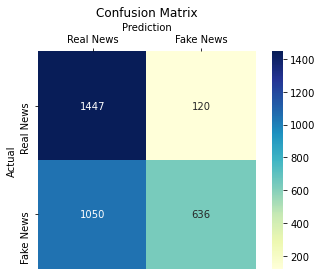

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

logit = LogisticRegression(max_iter=10000, C=300)
logit.fit(X_train_tfidf2,y_train)

#y_predict = logit.predict(X_test_tfidf2)
y_predict = (logit.predict_proba(X_test_tfidf2)[:, 1] >= 0.72)

#print("\nDefault threshold: 0.5")
print("Precision: {:6.4f}%,   Recall: {:6.4f}%".format(100*precision_score(y_test, y_predict), 
                                                     100*recall_score(y_test, y_predict)))

print("\nF1 score = {:6.4f}% ".format(100*f1_score(y_test, y_predict)))


# Print confusion matrix for kNN
f, ax = plt.subplots(figsize=(6, 4))
confusionmatrix = confusion_matrix(y_test, y_predict)
sns.heatmap(confusionmatrix, cmap="YlGnBu", annot=True, square=True,fmt ='g',xticklabels=['Real News', 'Fake News'], yticklabels=['Real News', 'Fake News'])

ax.set_title('Confusion Matrix')
ax.set_ylabel('Actual')
ax.set_xlabel('Prediction')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.savefig("matrix.svg")

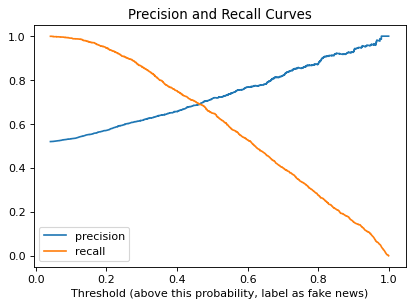

In [61]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logit.predict_proba(X_test_tfidf2)[:, 1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fake news)');
plt.title('Precision and Recall Curves');
plt.savefig("pr_curve.svg")

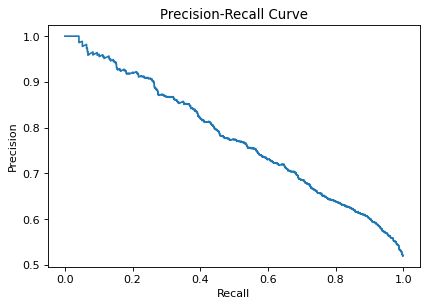

In [62]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");
plt.savefig("prcurve2.svg")

In [63]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, logit.predict_proba(X_test_tfidf2)[:,1])

ROC AUC score =  0.7526402726458594


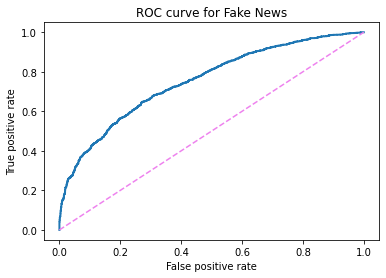

In [64]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Fake News');
plt.savefig("ROC_RC.svg")
print("ROC AUC score = ", roc_auc_score(y_test, logit.predict_proba(X_test_tfidf2)[:,1]))

In [65]:
from sklearn.metrics import log_loss

print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, logit.predict_proba(X_test_tfidf2)[:,1] )))

Log-loss on logit: 0.5891


In [66]:
df_predicted = pd.DataFrame(y_predict)
df_predicted.rename(columns={0:'Label'}, inplace=True)
df_predicted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3253 entries, 0 to 3252
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Label   3253 non-null   bool 
dtypes: bool(1)
memory usage: 3.3 KB


In [67]:
X_test1 = X_test
X_test1 = X_test1.reset_index()

In [68]:
X_test1 = X_test1.drop(['index'], axis = 1)

In [69]:
X_test1.head(5)

refine_Content
0  in a letter to the editor published in the mar...
1  candidate for california governor antonio vill...
2  after michigan turned away from barack obama i...
3  the group opposing amendment citizens for lowe...
4  a january chemical spill in west virginia that...

In [70]:
result = pd.concat([df_predicted, X_test1], axis=1)

In [71]:
result.head(5)

Label                                     refine_Content
0  False  in a letter to the editor published in the mar...
1  False  candidate for california governor antonio vill...
2  False  after michigan turned away from barack obama i...
3  False  the group opposing amendment citizens for lowe...
4  False  a january chemical spill in west virginia that...

## Topic Modelling

In [72]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,3), binary=True, stop_words='english', min_df = 0.1)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)



In [73]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,3), binary=True, stop_words='english', min_df = 0.1)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

## NMF

In [74]:
nmf_model = NMF(2, random_state = 1000, max_iter = 10000) #random state is a must, else topic will keep changing
X_train_nmf_cv1 = nmf_model.fit_transform(X_train_cv1)


In [75]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2"],
             columns = cv1.get_feature_names())
topic_word

aa    aaa  aaacom   aaam  aaamid   aaan  aaans  aaargh  aaas  \
component_1  0.009  0.018     0.0  0.001     0.0  0.003    0.0     0.0   0.0   
component_2  0.000  0.000     0.0  0.000     0.0  0.000    0.0     0.0   0.0   

             aaau  ...  ѕuсh  ѕаtіrе  ѕоund  ѕосіаl   іf   іn   іt   іѕ  \
component_1   0.0  ...   0.0     0.0    0.0     0.0  0.0  0.0  0.0  0.0   
component_2   0.0  ...   0.0     0.0    0.0     0.0  0.0  0.0  0.0  0.0   

             ḍozen  ﬁrearm  
component_1    0.0     0.0  
component_2    0.0     0.0  

[2 rows x 227811 columns]

In [76]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [77]:
display_topics(nmf_model, cv1.get_feature_names(), 15)


Topic  0
said, state, percent, health, people, law, states, new, obama, federal, care, million, president, year, government

Topic  1
tax, percent, taxes, income, rate, state, cuts, year, pay, billion, said, budget, increase, plan, million


In [78]:
H = pd.DataFrame(X_train_nmf_cv1.round(5),
             index = X_train,
             columns = ["component_1","component_2" ])
H.head(5)

component_1  component_2
refine_Content                                                              
the super pac ending spending fund is broadcast...      0.35355      0.00000
a widespread internet post claims democratic pr...      0.15625      0.00000
cnn host piers morgan has joined the chorus of ...      0.27541      0.14017
on sept the national taxpayers union a conserva...      0.11249      1.02977
del ken plum dfairfax recently renewed his call...      0.35407      0.08075

## LDA

In [79]:
from gensim import corpora, models, similarities, matutils
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [80]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", min_df = 0.1)

count_vectorizer.fit(X_train)

# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = count_vectorizer.transform(X_train).transpose()



In [81]:
import pandas as pd

#pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()
pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()

0      1      2      3      4      5      6      7      8      \
able           0      0      0      0      0      0      1      0      0   
according      3      1      0      2      1      0      0      1      0   
account        0      0      0      0      0      0      0      0      0   
accurate       1      0      1      1      0      1      0      0      0   
act            0      0      0      0      0      0      8      0      2   

           9      ...  13001  13002  13003  13004  13005  13006  13007  13008  \
able           0  ...      0      0      0      0      0      0      0      0   
according      0  ...      1      0      0      0      0      0      1      2   
account        0  ...      0      0      0      0      0      0      0      1   
accurate       1  ...      1      0      0      0      0      0      0      0   
act            0  ...      0      0      0      2      0      0      0      0   

           13009  13010  
able           0      0  
according      1      0  
account        0      0  
accurate       0      0  
act            0      0  

[5 rows x 13011 columns]

In [82]:
doc_word.shape

(423, 13011)

In [83]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

In [84]:
#id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [85]:
len(id2word)

423

In [86]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5, random_state = 123)

2020-10-27 01:11:22,836 : INFO : using symmetric alpha at 0.3333333333333333
2020-10-27 01:11:22,839 : INFO : using symmetric eta at 0.3333333333333333
2020-10-27 01:11:22,841 : INFO : using serial LDA version on this node
2020-10-27 01:11:22,846 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 13011 documents, updating model once every 2000 documents, evaluating perplexity every 13011 documents, iterating 50x with a convergence threshold of 0.001000
2020-10-27 01:11:22,892 : INFO : PROGRESS: pass 0, at document #2000/13011
2020-10-27 01:11:24,896 : INFO : merging changes from 2000 documents into a model of 13011 documents
2020-10-27 01:11:24,897 : INFO : topic #0 (0.333): 0.038*"said" + 0.020*"state" + 0.017*"percent" + 0.012*"trump" + 0.010*"people" + 0.010*"year" + 0.009*"new" + 0.009*"states" + 0.009*"president" + 0.008*"tax"
2020-10-27 01:11:24,898 : INFO : topic #1 (0.333): 0.030*"said" + 0.018*"percent" + 0.017*"tax" + 0.014*"stat

2020-10-27 01:11:40,268 : INFO : topic #2 (0.333): 0.040*"said" + 0.013*"law" + 0.013*"trump" + 0.013*"obama" + 0.011*"president" + 0.011*"campaign" + 0.010*"state" + 0.010*"people" + 0.010*"news" + 0.010*"did"
2020-10-27 01:11:40,269 : INFO : topic diff=0.039316, rho=0.342886
2020-10-27 01:11:40,320 : INFO : PROGRESS: pass 1, at document #6000/13011
2020-10-27 01:11:42,065 : INFO : merging changes from 2000 documents into a model of 13011 documents
2020-10-27 01:11:42,067 : INFO : topic #0 (0.333): 0.029*"state" + 0.027*"said" + 0.022*"percent" + 0.016*"year" + 0.015*"million" + 0.014*"budget" + 0.014*"jobs" + 0.013*"billion" + 0.011*"years" + 0.010*"spending"
2020-10-27 01:11:42,069 : INFO : topic #1 (0.333): 0.043*"tax" + 0.035*"percent" + 0.028*"health" + 0.026*"said" + 0.017*"care" + 0.016*"people" + 0.014*"taxes" + 0.014*"income" + 0.013*"rate" + 0.013*"state"
2020-10-27 01:11:42,071 : INFO : topic #2 (0.333): 0.040*"said" + 0.013*"trump" + 0.012*"law" + 0.012*"obama" + 0.011*"pr

2020-10-27 01:11:56,520 : INFO : topic diff=0.032711, rho=0.324349
2020-10-27 01:11:56,592 : INFO : PROGRESS: pass 2, at document #10000/13011
2020-10-27 01:11:58,135 : INFO : merging changes from 2000 documents into a model of 13011 documents
2020-10-27 01:11:58,136 : INFO : topic #0 (0.333): 0.030*"state" + 0.027*"said" + 0.025*"percent" + 0.017*"million" + 0.017*"year" + 0.014*"budget" + 0.013*"jobs" + 0.012*"billion" + 0.012*"years" + 0.011*"data"
2020-10-27 01:11:58,138 : INFO : topic #1 (0.333): 0.054*"tax" + 0.041*"health" + 0.033*"percent" + 0.027*"care" + 0.024*"said" + 0.017*"insurance" + 0.017*"taxes" + 0.017*"people" + 0.016*"income" + 0.014*"plan"
2020-10-27 01:11:58,139 : INFO : topic #2 (0.333): 0.040*"said" + 0.013*"trump" + 0.013*"obama" + 0.012*"law" + 0.012*"president" + 0.010*"state" + 0.010*"news" + 0.010*"campaign" + 0.010*"people" + 0.010*"did"
2020-10-27 01:11:58,140 : INFO : topic diff=0.033587, rho=0.324349
2020-10-27 01:11:58,205 : INFO : PROGRESS: pass 2, at

2020-10-27 01:12:12,724 : INFO : PROGRESS: pass 3, at document #13011/13011
2020-10-27 01:12:13,508 : INFO : merging changes from 1011 documents into a model of 13011 documents
2020-10-27 01:12:13,510 : INFO : topic #0 (0.333): 0.031*"state" + 0.030*"percent" + 0.027*"said" + 0.017*"million" + 0.016*"year" + 0.012*"jobs" + 0.012*"budget" + 0.012*"data" + 0.011*"years" + 0.011*"billion"
2020-10-27 01:12:13,510 : INFO : topic #1 (0.333): 0.062*"tax" + 0.046*"health" + 0.029*"care" + 0.027*"percent" + 0.021*"said" + 0.020*"taxes" + 0.018*"income" + 0.018*"insurance" + 0.017*"plan" + 0.016*"people"
2020-10-27 01:12:13,512 : INFO : topic #2 (0.333): 0.041*"said" + 0.013*"trump" + 0.013*"obama" + 0.012*"law" + 0.012*"president" + 0.011*"campaign" + 0.011*"state" + 0.010*"people" + 0.010*"news" + 0.010*"house"
2020-10-27 01:12:13,513 : INFO : topic diff=0.038614, rho=0.308526
2020-10-27 01:12:13,558 : INFO : PROGRESS: pass 4, at document #2000/13011
2020-10-27 01:12:14,918 : INFO : merging ch

In [87]:
lda.print_topics()

2020-10-27 01:12:26,186 : INFO : topic #0 (0.333): 0.031*"percent" + 0.031*"state" + 0.028*"said" + 0.017*"million" + 0.016*"year" + 0.012*"jobs" + 0.012*"data" + 0.011*"years" + 0.011*"states" + 0.011*"number"
2020-10-27 01:12:26,188 : INFO : topic #1 (0.333): 0.064*"tax" + 0.048*"health" + 0.030*"care" + 0.024*"percent" + 0.020*"taxes" + 0.020*"said" + 0.019*"income" + 0.018*"insurance" + 0.018*"plan" + 0.015*"people"
2020-10-27 01:12:26,190 : INFO : topic #2 (0.333): 0.041*"said" + 0.014*"trump" + 0.013*"obama" + 0.013*"law" + 0.012*"president" + 0.011*"campaign" + 0.010*"state" + 0.010*"people" + 0.010*"news" + 0.010*"house"


[(0,
  '0.031*"percent" + 0.031*"state" + 0.028*"said" + 0.017*"million" + 0.016*"year" + 0.012*"jobs" + 0.012*"data" + 0.011*"years" + 0.011*"states" + 0.011*"number"'),
 (1,
  '0.064*"tax" + 0.048*"health" + 0.030*"care" + 0.024*"percent" + 0.020*"taxes" + 0.020*"said" + 0.019*"income" + 0.018*"insurance" + 0.018*"plan" + 0.015*"people"'),
 (2,
  '0.041*"said" + 0.014*"trump" + 0.013*"obama" + 0.013*"law" + 0.012*"president" + 0.011*"campaign" + 0.010*"state" + 0.010*"people" + 0.010*"news" + 0.010*"house"')]

In [88]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [89]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [90]:
# Check out the document vectors in the topic space for the first 5 documents
#Topic distribution in each document
lda_docs[0:5]

[[(0, 0.24145049), (2, 0.75611454)],
 [(0, 0.18519065), (2, 0.81083924)],
 [(0, 0.9680591), (2, 0.02928554)],
 [(0, 0.115020365), (1, 0.8060327), (2, 0.078946926)],
 [(0, 0.8652366), (1, 0.1328561)]]

In [91]:
print(lda_corpus)

In [92]:
X_train.head(5)

12332    the super pac ending spending fund is broadcas...
10979    a widespread internet post claims democratic p...
13671    cnn host piers morgan has joined the chorus of...
11374    on sept the national taxpayers union a conserv...
13635    del ken plum dfairfax recently renewed his cal...
Name: refine_Content, dtype: object